# COMSOL Study: Parameter sweeps


## Bias voltage 100 and 1000 V


- new chamber
- microwave extraction aperture (1 mm diameter)
- surface mesh
- 5000 particles

- only **last timestep** is imported






### Import statements

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import re
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import kde
from scipy import optimize
from matplotlib.ticker import NullFormatter
from matplotlib import pyplot, transforms

pd.set_option("display.max_columns", 300)

### Specify path to datafile

In [2]:
foldername = '03.new_chamber/06.suppr_elec.design_v2/particleData/'

remote_path = f'/Users/hkromer/02_PhD/02_Data/01_COMSOL/\
01_IonOptics/{foldername}/'

### Function definitions

In [3]:
# fit a tophat function
def tophat(x, base_level, hat_level, hat_mid, hat_width):
	return np.where((hat_mid - hat_width / 2. < x) &
					(x < hat_mid + hat_width / 2.), hat_level, base_level)


def objective(params, x, y):
	return np.sum(np.abs(tophat(x, *params) - y))


def find_center_of_spot(y, x, qry_eval):
	# input:
	#  y: gaussian fit values along y (x=0)
	#  x: corresponding x values
	#  qry_eval: query points for the vertical and horizontal line

	idx_max = np.argmax(y)
	x_at_max = x[idx_max]

	idx_centerline_x = (np.abs(qry_eval - x_at_max)).argmin()
	# print(x_at_max)
	return x_at_max, idx_centerline_x


### Sweep parameter preparation

Taken from notion page

In [4]:
dict_sweep = {'sweep_values': [100, 1000]}


df_sweep_params = pd.DataFrame(dict_sweep)
print(df_sweep_params)
print(df_sweep_params.info())

   sweep_values
0           100
1          1000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 1 columns):
sweep_values    2 non-null int64
dtypes: int64(1)
memory usage: 96.0 bytes
None


### Which COMSOL data files are in the folder for processing 

In [5]:
COMSOL_data_file_path = remote_path

COMSOL_files = os.listdir(COMSOL_data_file_path)
COMSOL_files = [f for f in COMSOL_files if 'particleData' in f]
COMSOL_files = [f for f in COMSOL_files if f.endswith('.csv')]
COMSOL_files = [f for f in COMSOL_files if '011' in f]
COMSOL_files = [f'{COMSOL_data_file_path}{f}' for f in COMSOL_files]
print(COMSOL_files)
print(len(COMSOL_files))

['/Users/hkromer/02_PhD/02_Data/01_COMSOL/01_IonOptics/03.new_chamber/06.suppr_elec.design_v2/particleData//06.suppr_elec.design_v2.particleData.011.csv']
1


### Loop through the COMSOL files loading the particle data into the main dataframe df_data

Doing file 06.suppr_elec.design_v2.particleData.011.csv which is ID 011
 
***Now doing V_bias=1000
 
100.0% of the initial 5000 particles have arrived at the target (x > 10.0 mm and x < 140.0 mm).


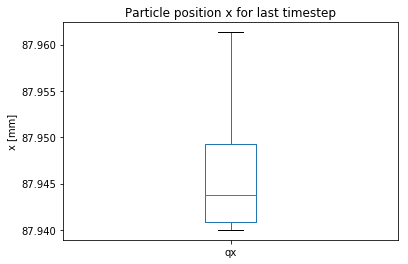

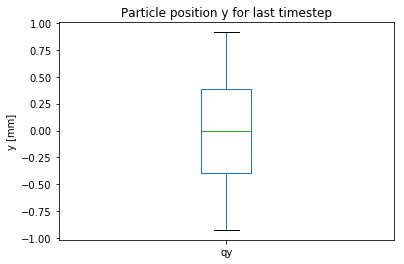

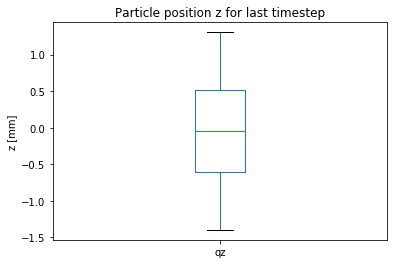

******Doing plots...
 
***Now doing V_bias=100
 
100.0% of the initial 5000 particles have arrived at the target (x > 10.0 mm and x < 140.0 mm).


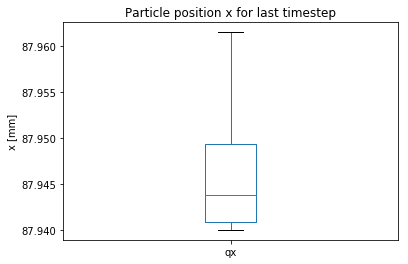

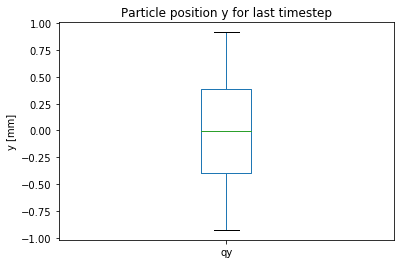

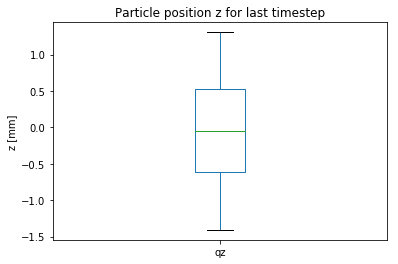

******Doing plots...


In [6]:
df_output = pd.DataFrame()

for COMSOL_data_file in COMSOL_files:

    runfile = re.findall(r'[^/]+(?=/$|$)', COMSOL_data_file)[0]
    
    # get the file ID from runfile (to get more info on the sweep)
    run_ID = re.findall(r'\.particleData\.(\d\d\d)\.csv', runfile)[0]
    
    # select only one run_ID
#     if run_ID == '006':
#         pass
#     else: 
#         continue
    
    print(f'Doing file {runfile} which is ID {run_ID}')
    
    # import the data
    df_data = pd.read_csv(COMSOL_data_file, skiprows=8, header=None)
    df_data['ID'] = run_ID
    df_data.set_index('ID', inplace=True)
    
    # process the column
    # find column headers
    c = []
    with open(COMSOL_data_file, 'r') as myfile:
        for line in myfile:
            if 'Index' in line:
                l = line.rstrip().split(',')
                c.append(l)

    myfile.close()
    cols = c[0]
    for ii in range(0, len(cols)):
        c = cols[ii]
        if 'qx' in c:
            cols[ii] = 'qx'
        if 'qy' in c:
            cols[ii] = 'qy'
        if 'qz' in c:
            cols[ii] = 'qz'
        if 'Index' in c:
            cols[ii] = 'particleIndex'
    
    # loop over the indices 1, 3 and so on. Combine the column names
    cols_1 = cols[1::2]
    cols_2 = [c.strip() for c in cols[2::2]]
    
    cols_out = [cols[0]]
    for ii in range(0, len(cols_1)):
        cols_out.append(cols_1[ii] + '_' + cols_2[ii])
   
    # set the new column names
    df_data.columns = cols_out

    # distinct column names in cols_2 is the different sweep settings
    cols_dist = list(set(cols_2))
    
    # loop over each sweep_setting
    for sweep_val in cols_dist:
        df_FWHM = pd.DataFrame()
        cols_to_select = [item for item in df_data.columns if item.endswith(sweep_val)]
        df_data_sweep = df_data.loc[:, cols_to_select]
#         print(df_data_sweep.head())
        print(' ')
        print(f'***Now doing {sweep_val}')
        print(' ') 
        # length: total number of particles
        n_total = len(df_data_sweep)

        # only those particles that have made it to the target: 10 mm in +x direction
        # for dist in [1,5,10,80]:
        dist_min = 10.0
        dist_max = 140.0  # needs to be adjusted for the 10.run
        df_arrived = df_data_sweep[ (df_data_sweep.iloc[:,0] > dist_min) &(df_data_sweep.iloc[:,0] < dist_max) ]
        n_arrived = len(df_arrived)

        # percent of those that have arrived
        perc_arrived = round((n_arrived / n_total)*100.0,2)

        print('{}% of the initial {} particles have arrived at the target (x > {} mm and x < {} mm).'.format(perc_arrived, n_total, dist_min, dist_max))
        if perc_arrived < 10:
            print('{}% smaller than 10 %, avoid this file).'.format(perc_arrived))
            continue
        # print(df.head())
        # print(sys.exit())

        cols = df_arrived.columns

        assert 'qx' in cols[0]
        assert 'qy' in cols[1]
        assert 'qz' in cols[2]
#         print(df_arrived)

        df_arrived.columns = ['qx', 'qy', 'qz']

        df_arrived.plot(kind='box', y='qx')
        plt.title('Particle position x for last timestep')
        plt.ylabel('x [mm]')
        df_arrived.plot(kind='box', y='qy')
        plt.title('Particle position y for last timestep')
        plt.ylabel('y [mm]')
        df_arrived.plot(kind='box', y='qz')
        plt.title('Particle position z for last timestep')
        plt.ylabel('z [mm]')
        plt.show()

        print(f'******Doing plots...')
        # compute beam radius
        this_df = df_data_sweep

        qy = this_df.iloc[:,1]
        qz = this_df.iloc[:,2]

        fname = re.findall(r'/([\w.]+).csv',COMSOL_data_file)[0]
        # print(fname)
        directory = '{}/plots/2D_histograms_lastTimestep'.format(COMSOL_data_file_path,fname)
        if not os.path.exists(directory):
            os.makedirs(directory)

        qx = this_df.iloc[:,0]
        median_qx = np.median(qx)
        qy = this_df.iloc[:,1]
        qz = this_df.iloc[:,2]
        qr = np.sqrt(qy**2+qz**2)

        nbins = 200
        if run_ID == '006':
            lim = 6
        else:
            lim = 3
        x = qy
        y = qz
        data = np.vstack([qy, qz])
        k = kde.gaussian_kde(data)
        # xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
        xi, yi = np.mgrid[-lim:lim:nbins*1j, -lim:lim:nbins*1j]
        zi = k(np.vstack([xi.flatten(), yi.flatten()]))
        df_histData = pd.DataFrame()

        df_histData['qx'] = qx
        df_histData['qy'] = qy
        df_histData['qz'] = qz

        # compute FWHM for all points parallel to the x and y axis
        qry_eval = np.linspace(-lim, lim, 100)
        y_values = [k.evaluate([0, y])[0] for y in qry_eval]

        eval_y = y_values


        # print(kint)
        df_res = pd.DataFrame()
        df_res['qry_eval'] = qry_eval
        df_res['eval_y'] = eval_y

        # fit FWHM
        # Create a function which returns a Gaussian (normal) distribution.
        def gauss(p, x):
            a, b, c, d = p
            y = a*np.exp(-np.power((x - b), 2.)/(2. * c**2.)) + d
            return y
        def errfunc(p, x, y):
            return gauss(p, x) - y # Distance to the fit function

        p0 = [1, 1, 1, 1] # Initial guess for the parameters

        # fit for parallel to y axis
        X_f = qry_eval
        Y_f = eval_y
        # print(df.norm_cps)
        # print(X_f, Y_f)
        p1, success = optimize.leastsq(errfunc, p0[:], args=(X_f, Y_f))
        Y_fit = gauss(p1, X_f)
        # save df to csv
        df_FWHM_y = pd.DataFrame(X_f, columns=['X_fit'])
        df_FWHM_y['Y_fit'] = Y_fit
        df_FWHM_y['sigma'] = p1[2]  # sigma in gaussian
        df_FWHM_y['FWHM'] = 2.08 * p1[2] * np.sqrt(2 * np.log(2))  # FWHM
        # fname = f'{master_folder}/df_FWHM_y.csv'
        # df_FWHM_y.to_csv(fname)
        df_FWHM['FWHM_y'] = df_FWHM_y['FWHM'].unique()


        # find maximum position of gaussian fit along y
        # to find center of 03_BeamOptics
        val_x, qry_x = find_center_of_spot(df_FWHM_y['Y_fit'].values,
                                    df_FWHM_y['X_fit'].values,
                                    qry_eval)

        # print(qry_x)
        # sys.exit()
        # qry_eval = np.linspace(-lim, lim, 100)
        eval_x = [k.evaluate([x, val_x])[0] for x in qry_eval]
        # print(eval_x)
        df_res['eval_x'] = eval_x
        # fit for parallel to x axis
        X_f = qry_eval
        Y_f = eval_x
        # print(df.norm_cps)
        # print(X_f, Y_f)
        p1, success = optimize.leastsq(errfunc, p0[:], args=(X_f, Y_f), maxfev=100000)
        Y_fit = gauss(p1, X_f)
        # save df to csv
        df_FWHM_x = pd.DataFrame(X_f, columns=['X_fit'])
        df_FWHM_x['Y_fit'] = Y_fit
        df_FWHM_x['sigma'] = p1[2]  # sigma in gaussian
        df_FWHM_x['FWHM'] = 2.08 * p1[2] * np.sqrt(2 * np.log(2))  # FWHM
        # fname = f'{master_folder}/df_FWHM_x.csv'
        # df_FWHM_x.to_csv(fname)
        df_FWHM['FWHM_x'] = df_FWHM_x['FWHM'].unique()

        df_FWHM['FWHM'] = (np.abs(df_FWHM['FWHM_y']) +
                            np.abs(df_FWHM['FWHM_x'])) / 2.0

        # plt.plot(X_f, eval_x)
        # plt.show()
        # sys.exit()

        # tophat
        tophat_params = [ [0, 0, 0, 0], [0, 0, 0, 0] ]  # x, y
        for eval, mode in zip([eval_x, eval_y], ['hat_x_width', 'hat_y_width']):
            guess = [0, 0.3, 0, 2] # (base_level, hat_level, hat_mid, hat_width)
            res = minimize(objective, guess, args=(X_f, eval),
                method='Nelder-Mead',
                options={'maxfev': 10000000})
            # plt.plot(X_f, tophat(X_f, *(res.x)))
            df_FWHM[mode] = res.x[3]
            if mode == 'hat_x_width':
                tophat_params[0] = res.x
            else:
                tophat_params[1] = res.x



        f = plt.figure(1, figsize=(7.5, 7.5))

        nullfmt = NullFormatter()         # no labels

        # definitions for the axes
        left, width = 0.10, 0.6
        bottom, height = 0.10, 0.6
        bottom_h = left_h = left + width + 0.02

        rect_scatter = [left, bottom, width, height]
        rect_histx = [left, bottom_h, width, 0.2]
        rect_histy = [left_h, bottom, 0.2, height]

        axScatter = plt.axes(rect_scatter)

        axHistx = plt.axes(rect_histx)
        plt.title(f'{runfile}- {sweep_val}')
        axHisty = plt.axes(rect_histy)

        # no labels
        axHistx.xaxis.set_major_formatter(nullfmt)
        axHisty.yaxis.set_major_formatter(nullfmt)
        axHistx.grid(True)
        axHisty.grid(True)


        p = axScatter.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.jet)
        axScatter.set_xlabel('y [mm]')
        axScatter.set_ylabel('z [mm]')

        # contours = axScatter.contour(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.Blues, levels=[my_lvl])
        # plt.clabel(contours, inline=True, fontsize=8)
        axScatter.set_facecolor('#000080ff')
        plt.colorbar(p)

        # compute FWHM for all x and y histograms
        # select the largest FWHM

        axScatter.set_xlim((-lim, lim))
        axScatter.set_ylim((-lim, lim))

        # left = 0.8
        # bottom = 0.12
        # width = 0.05
        # height = 0.65
        #
        # cax = f.add_axes([left, bottom, width, height])
        # cbar = f.colorbar(p, cax)
        #
        # cbar.ax.tick_params(labelsize=12)
        #
        # plt.subplots_adjust(left=None, bottom=0.2, right=None, top=0.68,
        # wspace=None, hspace=0.2)

        # compute FWHM for all points parallel to the x and y axis
        # qry_eval = np.linspace(-lim,lim,100)
        # eval_x = [k.evaluate([x,0])[0] for x in qry_eval]
        # eval_y = [k.evaluate([0,y])[0] for y in qry_eval]

        # # print(kint)
        # #
        # df_res = pd.DataFrame()
        # df_res['qry_eval'] = qry_eval
        # df_res['eval_x'] = eval_x
        # df_res['eval_y'] = eval_y
        # # df_res['kint_1'] = kint
        # df_res['type_file'] = type_file
        # # df_res['contour_level'] = my_lvl
        # fwhm_x = calculateFWHM(qry_eval,df_res['eval_x'])
        # fwhm_y = calculateFWHM(qry_eval,df_res['eval_y'])


        # first of all, the base transformation of the data points is needed
        base = pyplot.gca().transData
        rot = transforms.Affine2D().rotate_deg(270)
        axScatter.plot([-lim, lim], [val_x, val_x], color='black', linestyle='dashed')
        axScatter.plot([0, 0], [-lim, lim], color='black')
        plt.axis('equal')
        # print(tophat_params)
        axHistx.plot(df_res['qry_eval'].values, df_res['eval_x'], c='black', linestyle='dashed')
        axHistx.plot(df_FWHM_x['X_fit'], df_FWHM_x['Y_fit'], c='red', linestyle='dotted')
        axHistx.plot(df_FWHM_x['X_fit'], tophat(df_FWHM_x['X_fit'], *(tophat_params[0])), c='green', linestyle='dotted')
        axHisty.plot(df_res['qry_eval'].values, df_res['eval_y'].values[::-1], c='black', transform= rot + base)
        axHisty.plot(df_FWHM_y['X_fit'], df_FWHM_y['Y_fit'].values[::-1], c='red', linestyle='dotted', transform= rot + base)
        # axHisty.plot(df_FWHM_y['X_fit'], tophat(df_FWHM_y['X_fit'], *(tophat_params[1]))[::-1], c='green', linestyle='dotted', transform= rot + base)


        axHistx.set_xlim(axScatter.get_xlim())
        axHisty.set_ylim(axScatter.get_ylim())

        # f.tight_layout()
        # df_x_FWHM, df_y_FWHM = getLargestFWHM(k, lim)

        # df_x_FWHM.to_csv('{}/df_x_FWHM.csv'.format(directory))
        # df_y_FWHM.to_csv('{}/df_y_FWHM.csv'.format(directory))

        # plt.show()

        filename =  '{}/{}_{}'.format(directory, runfile, sweep_val)
        df_histData.to_csv(f'{filename}_df_histData.csv')
        # print(nn)
        # plt.savefig(filename + '.eps', dpi=1200)
        # plt.savefig(filename + '.svg', dpi=1200)
        plt.savefig(filename + '.png', dpi=600)

        plt.close('all')
        if 'BIDIR' in runfile:
            s_type = 'BIDIR'
        else:
            s_type = 'TD'
        # id = re.findall(r'(\d\d)\.', runfile)[0]
        df_FWHM['id'] = runfile
        df_FWHM['runfile'] = runfile
        df_FWHM['run_type'] = s_type
        df_FWHM['sweep_variable'] = sweep_val
        df_output = df_output.append(df_FWHM)
        # plt.show()

fname = f'{COMSOL_data_file_path}/plots/2D_histograms_lastTimestep/df_FWHMs.csv'
df_output = df_output.set_index('id').sort_index()
df_output.to_csv(fname)


    